In [ ]:
import cv2
import numpy as np
import requests
from google.colab.patches import cv2_imshow  # Only needed in Google Colab



--- Image Successfully Loaded Directly from URL ---


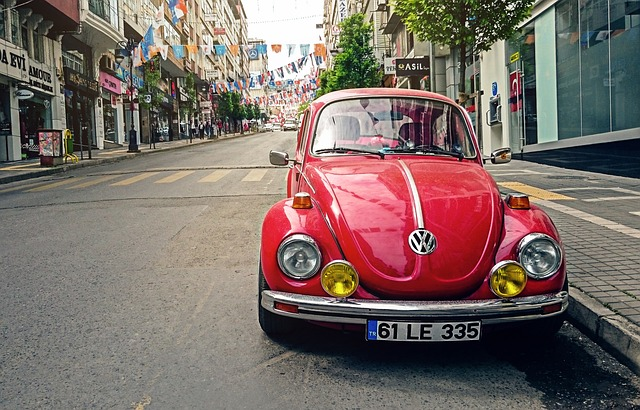

------------------------------


In [ ]:
image_url = "https://images.wsj.net/im-353549/?width=1280&size=1"
image_url =  "https://ix-cdn.b2e5.com/images/27094/27094_3063d356a3a54cc3859537fd23c5ba9d_1539205710.jpeg"

image_url =  "https://i.insider.com/646263e1785af800192b60db?width=700"

image_url =  "https://cdn.pixabay.com/photo/2016/11/21/18/07/automotive-1846910_640.jpg"


try:
    # 1. Download image content from URL
    response = requests.get(image_url)
    response.raise_for_status()

    # 2. Convert byte stream to NumPy array
    image_array = np.frombuffer(response.content, np.uint8)

    # 3. Decode the array into an OpenCV image format
    original_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

except requests.exceptions.RequestException as e:
    print(f"Error fetching the image: {e}")
    original_image = None

if original_image is not None:
    print("--- Image Successfully Loaded Directly from URL ---")
    cv2_imshow(original_image)
    print("-" * 30)


In [ ]:
# 🎯 Adjustable HSV Range - Modify this block only
target_color = "red" # Modify as u need

if target_color == "blue":
    lower_hsv = np.array([95, 80, 50])
    upper_hsv = np.array([135, 255, 255])
elif target_color == "red":
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([30, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])

elif target_color == "green":
    lower_hsv = np.array([40, 50, 50])
    upper_hsv = np.array([80, 255, 255])

elif target_color == "white":
    # White = low saturation, high brightness
    lower_hsv = np.array([0, 0, 200])
    upper_hsv = np.array([180, 50, 255])
# You can add more colors here...
else:
    raise ValueError("Color not supported")


--- HSV Image ---


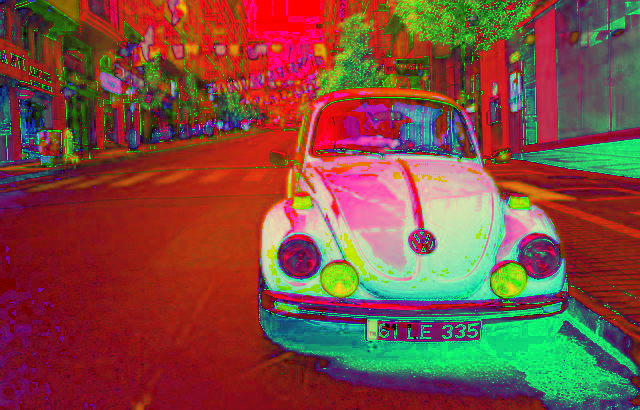

------------------------------


In [ ]:
hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
print("--- HSV Image ---")
cv2_imshow(hsv_image)
print("-" * 30)

--- Blurred Image ---


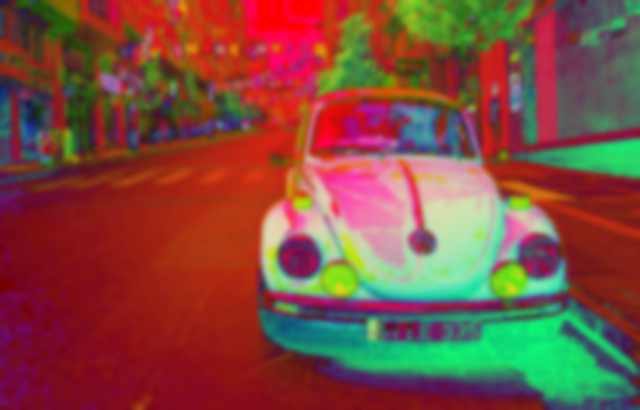

------------------------------


In [ ]:
# Stage 5: Apply Gaussian Blur for Noise Reduction
blurred_image = cv2.GaussianBlur(hsv_image, (15, 15), 0)
print("--- Blurred Image ---")
cv2_imshow(blurred_image)
print("-" * 30)

--- Red Color Mask ---


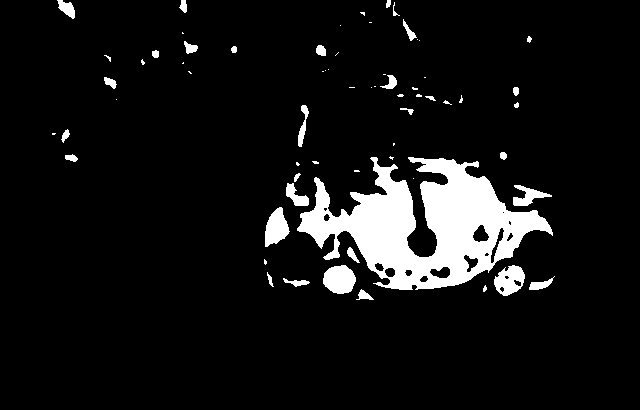

------------------------------


In [ ]:
# Stage 6: Color Segmentation

if target_color == "red":
    mask1 = cv2.inRange(blurred_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(blurred_image, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)
else:
    mask = cv2.inRange(blurred_image, lower_hsv, upper_hsv)

print(f"--- {target_color.capitalize()} Color Mask ---")
cv2_imshow(mask)
print("-" * 30)


--- Final Annotated Image ---


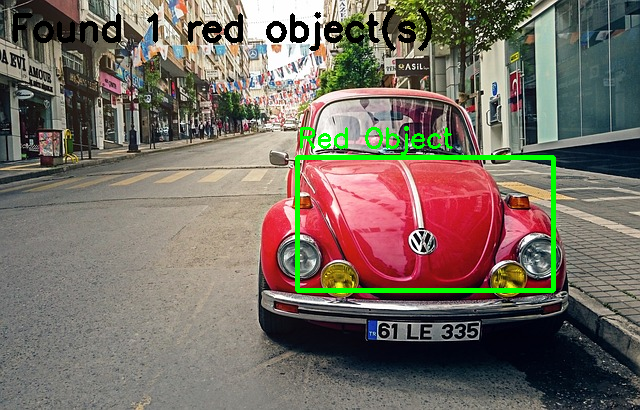

------------------------------


In [ ]:
#  Stage 7: Contour Detection
# Step 1: Find contours (edges) in the binary mask.
# The mask contains white regions where the target color was detected.
#
# cv2.RETR_EXTERNAL → Retrieves only the outer contours (ignores nested/inner ones).
# cv2.CHAIN_APPROX_SIMPLE → Compresses the contour points (removes redundant points for efficiency).

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image for drawing
output_image = original_image.copy()
object_count = 0  # Counter for detected objects

for cnt in contours:
    area = cv2.contourArea(cnt)
    ## If the area is too small (less than 3500), it is likely just noise or a small irrelevant blob.
    if area > 1000: # We ignore such small regions and only process objects larger than this threshold.
        object_count += 1
        x, y, w, h = cv2.boundingRect(cnt)
        # x, y: top-left corner of the object
        # w, h: width and height of the object
        # color: (0, 255, 0) → green
        # thickness: 3 pixels
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 3)

        cv2.putText(output_image, f"{target_color.capitalize()} Object",
                    (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


summary_text = f"Found {object_count} {target_color} object(s)"
cv2.putText(output_image, summary_text, (10, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)

print("--- Final Annotated Image ---")
cv2_imshow(output_image)
print("-" * 30)

# Detect objects by color using KMeans Clustering

In [ ]:
red = np.array([[40,40,200]])

In [ ]:
from sklearn.cluster import KMeans

# Reshape image to (pixels, 3)
pixel_vals = original_image.reshape((-1, 3))
pixel_vals = np.float32(pixel_vals)

n_cluster = 3
# Run KMeans
kmeans = KMeans(n_clusters=n_cluster)
kmeans.fit(pixel_vals)
centers = np.uint8(kmeans.cluster_centers_)

#
distance = np.linalg.norm(centers- red ,axis = 1)
closed_clusters = np.argmin(distance)

print("Best Cluster:", closed_clusters)


Best Cluster: 2
